https://medium.com/aimonks/multivariate-timeseries-analysis-using-tensorflow-9554e607077a#:~:text=In%20summary%2C%20multivariate%20time%20series,variables%20to%20improve%20prediction%20accuracy.

In [1]:
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import yfinance as yf
#from datetie import datetime

#Read the csv file
# df = pd.read_csv('data/GE.csv')
#df = yf.download('ADANIPOWER.NS', start = "2016-01-01", end = "2023-12-30")

#print(df.head()) #7 columns, including the Date.

In [2]:
df = pd.read_csv("Adani_Power.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,32.500000,34.400002,32.299999,34.000000,34.000000,12331921
1,2016-01-04,34.000000,34.700001,32.000000,32.700001,32.700001,15329003
2,2016-01-05,32.849998,34.599998,32.849998,34.299999,34.299999,12091589
3,2016-01-06,34.549999,35.150002,33.599998,34.500000,34.500000,12298429
4,2016-01-07,33.799999,33.799999,31.299999,32.000000,32.000000,10495393


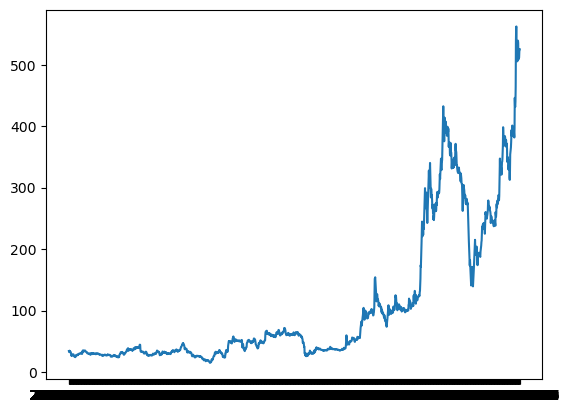

In [3]:
plt.figure()
plt.plot(df.Date, df.Close)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, GRU #can train using either GRU or LSTM

from sklearn.preprocessing import StandardScaler

In [5]:
# convert the Date column to DateTime from Object type
train_set_dates = pd.to_datetime(df['Date'])
train_set_dates.head()

# extract the required features (in this we are omiting the volume from feature list)
columns = list(df.columns[1:6])
print(columns)

df_train = df[columns].astype(float)
df_train.head()

# Normalize the data using the Standard scaler
standard_scaler = StandardScaler()
scalar = standard_scaler.fit(df_train)
scaled_training_df = scalar.transform(df_train)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [6]:
trainX = []
trainY = []

future_no_of_days = 1 # num of days to predict the future values
past_no_of_days = 14 # number of days on which the prediction is computed

for i in range(past_no_of_days, len(scaled_training_df) - future_no_of_days+1):
    trainX.append(scaled_training_df[i - past_no_of_days:i, 0:df_train.shape[1]])
    trainY.append(scaled_training_df[i + future_no_of_days - 1:i + future_no_of_days, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape: {}'.format(trainX.shape))
print('trainY shape: {}'.format(trainY.shape))

trainX shape: (1961, 14, 5)
trainY shape: (1961, 1)


In [7]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 64)            13632     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 23073 (90.13 KB)
Trainable params: 23073 (90.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50

111/111 [==============================] - 9s 29ms/step - loss: 0.1104 - val_loss: 0.0531
Epoch 2/50
111/111 [==============================] - 2s 18ms/step - loss: 0.0365 - val_loss: 0.0227
Epoch 3/50
111/111 [==============================] - 2s 16ms/step - loss: 0.0289 - val_loss: 0.0386
Epoch 4/50
111/111 [==============================] - 2s 20ms/step - loss: 0.0225 - val_loss: 0.0319
Epoch 5/50
111/111 [==============================] - 2s 21ms/step - loss: 0.0269 - val_loss: 0.0115
Epoch 6/50
111/111 [==============================] - 2s 17ms/step - loss: 0.0282 - val_loss: 0.0142
Epoch 7/50
111/111 [==============================] - 2s 16ms/step - loss: 0.0278 - val_loss: 0.0143
Epoch 8/50
111/111 [==============================] - 2s 14ms/step - loss: 0.0277 - val_loss: 0.0269
Epoch 9/50
111/111 [==============================] - 2s 14ms/step - loss: 0.0218 - val_loss: 0.0411
Epoch 10/50
111/111 [==============================] - 2s 15ms/step - loss: 0.0227 - val_l

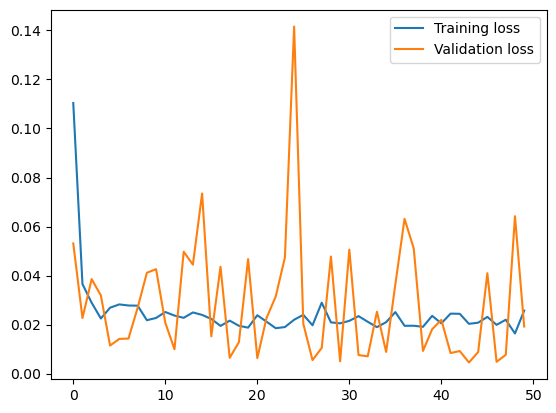

In [8]:
# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 90
n_days_for_prediction=90  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_set_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist() # instead of us_bd we can give '1d' etc.

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

# predict the future price
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_pred_future = scalar.inverse_transform(prediction_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-1-1'] # selecting the data only from 2023 just for our convinence


3/3 [==============================] - 1s 7ms/step


C:\Users\bnaga\AppData\Local\Temp\ipykernel_18480\432596278.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


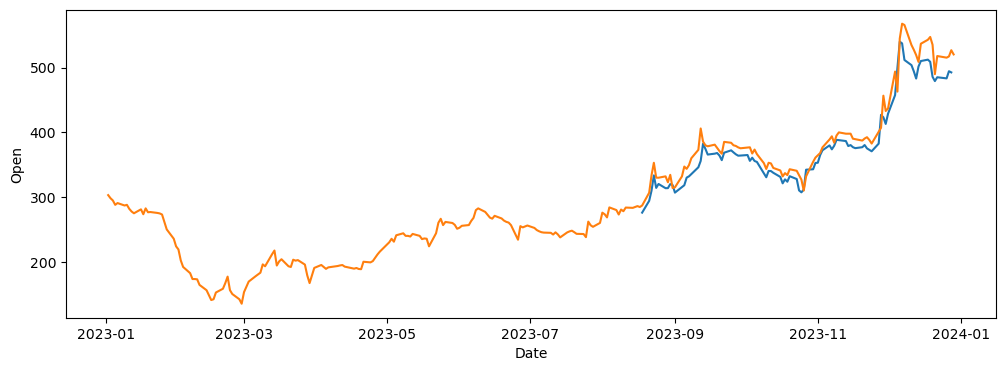

In [10]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df_forecast, x='Date', y='Open', )
sns.lineplot(data=original, x='Date', y='Open')
plt.show()